## Required Imports

In [1]:
# !pip install onc-toolbox
# !pip install gsw
# !pip install bokeh
# !pip install matplotlib
# !pip install xarray

## Setup

In [2]:
from bokeh.plotting import figure, show
from bokeh.palettes import TolRainbow15
from bokeh.models import Range1d
from bokeh.io import output_notebook

from datetime import datetime
import gsw
import matplotlib.pyplot as plt
import xarray as xr

from ONCToolbox import ONCToolbox, remove_onc_flags
from ONCToolbox.utils.climatology import fixed_baseline_climatology

output_notebook()

Loading BokehJS ...

In [3]:
loc_code = 'CBYIP'
resample_type = 'avg'
resample_period = 86400
out_as = 'xarray'
add_metadata = True

# Instantiate ONCToolbox class.
onct = ONCToolbox(timeout = 60 * 30)

# Year range to obtain data for.
years = range(2012, datetime.now().year + 1)

## Obtain Ice Profiler Data

In [4]:
dss = []
for year in years:
    date_from = datetime(year,1,1,0,0,0,0)
    date_to = datetime(year,12,31,23,59,59,999999)
    try: # Use try-catch because we are too lazy to look up info using deployments endpoint.
        _ds = onct.get_clean_data(location_code=loc_code,
                                  device_category_code='ICEPROFILER',
                                  resample_type=resample_type,
                                  resample_period = resample_period,
                                  date_from=date_from,
                                  date_to=date_to,
                                  out_as=out_as,
                                  property_code=['icedraft'],
                                  add_metadata=add_metadata)
    except:
        continue
    _ds = _ds.drop_vars([dv for dv in _ds.data_vars if dv.startswith('qaqc_flag')],errors = 'ignore')
    dss.append(_ds)
icepro = xr.concat(dss, dim = 'time',combine_attrs = 'drop_conflicts', join = 'outer', data_vars='all')
icepro = icepro.drop_duplicates(dim = 'time', keep = 'first')
icepro = icepro.sortby('time')
icepro = remove_onc_flags(icepro)

## Obtain TS Data 2012-2013

In [5]:
date_from = datetime(2012,1,1,0,0,0,0)
date_to = datetime(2015,12,31,23,59,59,999999)

_ds = onct.get_clean_data(location_code=loc_code,
                          device_category_code='WETLABS_WQM',
                          resample_type=resample_type,
                          resample_period = resample_period,
                          date_from=date_from,
                          date_to=date_to,
                          out_as=out_as,
                          property_code=['conductivity','seawatertemperature','pressure','salinity'],
                          add_metadata=add_metadata)
_ds = remove_onc_flags(_ds)

## Only keep variables that will help compute sea water density.
_ds = _ds[['practical_salinity','temperature','pressure','conductivity']]

# Rename variables to CF-compliant names so there are no conflicts when merging with ice profiler data.
_ds = _ds.rename({'conductivity': 'sea_water_electrical_conductivity',
                'temperature': 'sea_water_temperature',
                'practical_salinity': 'sea_water_practical_salinity',
                'pressure': 'sea_water_pressure'})

# Compute absolute salinity. Lat/lon are stored as attributes of the dataset, hence the 'add_metadata' kwarg in the get_clean_data() call.
sa = gsw.SA_from_SP(_ds.sea_water_practical_salinity, _ds.sea_water_pressure, _ds.attrs['lon'], _ds.attrs['lat'])

# Compute conservative temperature.
ct = gsw.CT_from_t(sa, _ds.sea_water_temperature, _ds.sea_water_pressure)

# Compute density and spiciness.
_ds['sea_water_density'] = gsw.density.rho(sa, ct, _ds.sea_water_pressure)
_ds['spiciness0'] = gsw.spiciness0(sa, ct)

wqm = _ds

## Obtain CTD Data 2014-Present

In [6]:
dss = []
for year in years:
    date_from = datetime(year,1,1,0,0,0,0)
    date_to = datetime(year,12,31,23,59,59,999999)
    try: # Use try-catch because we are too lazy to look up info using deployments endpoint.
        _ds = onct.get_clean_data(location_code=loc_code,
                                  device_category_code='CTD',
                                  resample_type=resample_type,
                                  resample_period = resample_period,
                                  date_from=date_from,
                                  date_to=date_to,
                                  out_as=out_as,
                                  property_code=['conductivity','seawatertemperature','pressure','salinity'],
                                  add_metadata=add_metadata)
    except:
        continue
    _ds = remove_onc_flags(_ds)

    # Remove old variables that can be recomputed later.
    _ds = _ds.drop_vars(['sigma-t','sigma-theta_0_dbar','sound_speed','density'], errors = 'ignore')

    # Rename variables to CF-compliant names so there are no conflicts when merging with ice profiler data.
    _ds = _ds.rename({'conductivity': 'sea_water_electrical_conductivity',
                    'temperature': 'sea_water_temperature',
                    'practical_salinity': 'sea_water_practical_salinity',
                    'pressure': 'sea_water_pressure'})

    # Compute absolute salinity. Lat/lon are stored as attributes of the dataset, hence the 'add_metadata' kwarg in the get_clean_data() call.
    sa = gsw.SA_from_SP(_ds.sea_water_practical_salinity, _ds.sea_water_pressure, _ds.attrs['lon'], _ds.attrs['lat'])

    # Compute conservative temperature.
    ct = gsw.CT_from_t(sa, _ds.sea_water_temperature, _ds.sea_water_pressure)

    # Compute density and spiciness.
    _ds['sea_water_density'] = gsw.density.rho(sa, ct, _ds.sea_water_pressure)
    _ds['spiciness0'] = gsw.spiciness0(sa, ct)

    dss.append(_ds)
ctd = xr.concat(dss, dim = 'time',combine_attrs = 'drop_conflicts', join = 'outer', data_vars='all')
ctd = ctd.drop_duplicates(dim = 'time', keep = 'first')
ctd = ctd.sortby('time')

## Merge Datasets and Compute Ice Thickness

In [7]:
combo = xr.combine_by_coords([icepro, ctd, wqm], combine_attrs='drop_conflicts', join='outer', data_vars = 'all', compat = 'no_conflicts')
combo = combo.dropna(dim = 'time', how = 'all')

local_ice_bulk_density = 850 # Or 917?
combo['ice_thickness'] = combo.ice_draft_corrected * (combo.sea_water_density/local_ice_bulk_density)

it = combo.ice_thickness.dropna(dim = 'time', how = 'all')
it = it.where(it >0, other = 0)

## Build Climatology
We'll port over the Hobday et al. (2016) method for building a climatology and threshold.

Building a climatology using Craig Risien's harmonic fit method or a LOESS filter would be better, but I'm lazy.

In [8]:
ref = it.sel(time = slice(datetime(2013,1,1), datetime(2024,12,31)))
clim_med = fixed_baseline_climatology(ref, half_window_width=5, use_circular = True, method = 'median', reset_to_input_time=False)
clim_mean = fixed_baseline_climatology(ref, half_window_width=5, use_circular = True, method = 'mean', reset_to_input_time=False)

q = fixed_baseline_climatology(ref, half_window_width=5, use_circular = True, method = [0.1,0.25,0.75,0.9], reset_to_input_time=False)
q10 = q.sel(quantile = 0.1)
q25 = q.sel(quantile = 0.25)
q75 = q.sel(quantile = 0.75)
q90 = q.sel(quantile = 0.9)

## Bokeh Plot

In [9]:
p = figure(width = 800, height = 600)
p.title.text = 'Ice Thickness at Ocean Networks Canada CBYIP'

p.hspan(y = 0, line_width = 1, line_color = 'black', )
p.varea(x = q10.dayofyear, y1 = q10, y2 = q90, fill_color = 'gray', fill_alpha = 0.25, legend_label = '10-90th Percentile (2013-2024)', muted_color = 'gray', muted_alpha = 0.05)
p.varea(x = q25.dayofyear, y1 = q25, y2 = q75, fill_color = 'gray', fill_alpha = 0.5, legend_label = '25-75th Percentile (2013-2024)', muted_color = 'gray', muted_alpha = 0.05, muted = True)

p.line(clim_med.dayofyear, clim_med, line_width = 2, color = 'black', alpha = 1, legend_label = 'Median (2013-2024)', line_dash = 'dashed', muted_color = 'black', muted_alpha = 0.1, muted = True)
p.line(clim_mean.dayofyear, clim_mean, line_width = 2, color = 'black', alpha = 1, legend_label = 'Mean (2013-2024)', line_dash = 'dotted', muted_color = 'black', muted_alpha = 0.1)

for year in years:
    _color = TolRainbow15[year % len(TolRainbow15)]
    _ds = it.sel(time = slice(datetime(year,1,1), datetime(year,12,31)))
    _ds = _ds.resample({'time': '1d'}).mean()
    if year in [2012,2025]:
        muted = False
    else:
        muted = True
    p.line(_ds['time.dayofyear'], _ds,line_width = 3, legend_label = str(year),color = _color,muted_color = _color, alpha = 1, line_dash = 'solid', muted_alpha = 0.1,muted = muted)

p.legend.location = 'top_right'
p.legend.click_policy = "mute"
p.legend.label_text_font_size = '10pt'
p.legend.ncols = 3

p.y_range = Range1d(-0.1, 2.5)
p.x_range = Range1d(1, 366)

p.xaxis.axis_label = 'Day of Year'
p.yaxis.axis_label = 'Ice Thickness (m)'

show(p)


## Matplotlib Plot

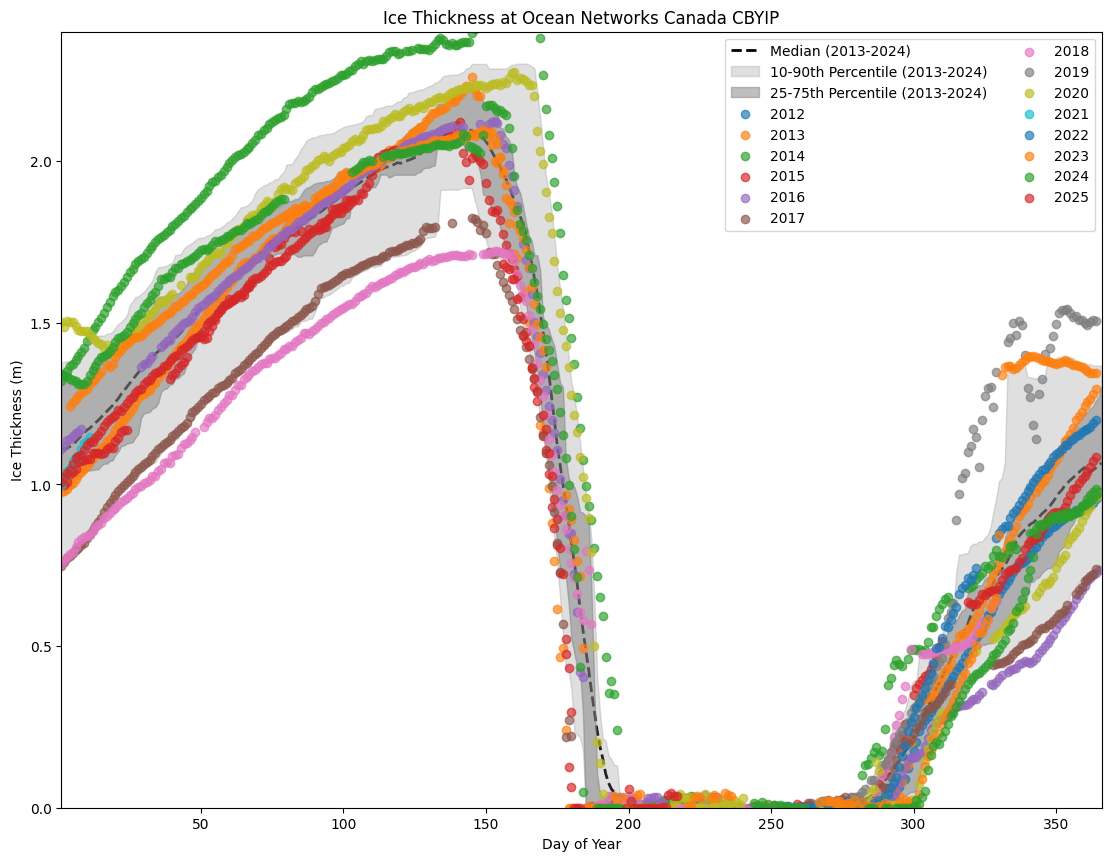

In [10]:
fig, ax = plt.subplots(1,1, figsize = (11,8.5), constrained_layout = True)
ax.plot(clim_mean.dayofyear, clim_mean, color = 'black', zorder = 0, linestyle = '--', linewidth = 2, label = 'Median (2013-2024)')


ax.fill_between(q10.dayofyear, q10, q90, color = 'gray', alpha = 0.25, zorder = 0, label = '10-90th Percentile (2013-2024)')
ax.fill_between(q25.dayofyear, q25, q75, color = 'gray', alpha = 0.5, zorder = 0, label = '25-75th Percentile (2013-2024)')


for year in years:
    _ds = it.sel(time = slice(datetime(year,1,1), datetime(year,12,31)))
    ax.scatter(_ds['time.dayofyear'], _ds, label = str(year), alpha = 0.67)


ax.legend(loc = 'upper right', fontsize = 10, ncol = 2)

ax.set_xlim(1,366)
ax.set_ylim(0, 2.4)
ax.set_ylabel('Ice Thickness (m)')
ax.set_xlabel('Day of Year')
ax.set_title('Ice Thickness at Ocean Networks Canada CBYIP')
plt.savefig('../figures/ice_thickness_example.jpg', dpi = 300)